In [60]:
# All necessary imports
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shap
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay as pdp
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tabulate import tabulate
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import xgboost as xgb

In [61]:
# Read datasets

train_data = pd.read_csv("train.csv", delimiter=";", low_memory=False)
test_data  = pd.read_csv("test.csv",  delimiter=";", low_memory=False)

## Initial Data Overview

We start with an initial exploration of the dataset to understand its structure, variables, and basic composition.

This step helps surface key features, detect data quality issues, and identify missing or sparsely populated columns early.

In [62]:
# Rename some columns for better readability
train_data = train_data.rename(columns={
    "w0": "cnt_bound_books",
    "w1": "cnt_paperback_books",
    "w2": "cnt_school_books",
    "w3": "cnt_ebooks",
    "w4": "cnt_audio_books",
    "w5": "cnt_audio_books_dl",
    "w6": "cnt_films",
    "w7": "cnt_music_items",
    "w8": "cnt_hardware_items",
    "w9": "cnt_imported_items",
    "w10": "cnt_other_items",
})

test_data = test_data.rename(columns={
    "w0": "cnt_bound_books",
    "w1": "cnt_paperback_books",
    "w2": "cnt_school_books",
    "w3": "cnt_ebooks",
    "w4": "cnt_audio_books",
    "w5": "cnt_audio_books_dl",
    "w6": "cnt_films",
    "w7": "cnt_music_items",
    "w8": "cnt_hardware_items",
    "w9": "cnt_imported_items",
    "w10": "cnt_other_items",
})

Data exploration - raw

In [63]:
result = pd.DataFrame()

# Basic counts
result['# obs'] = train_data.apply(lambda x: len(x))
result['# obs_nonnan'] = train_data.apply(lambda x: x.count())

# Data types
result['dtype'] = train_data.dtypes

# Cardinality
result['# unique'] = train_data.apply(lambda x: x.nunique())

# Numeric statistics only
result['mean'] = train_data.mean(numeric_only=True)
result['min'] = train_data.min(numeric_only=True)
result['max'] = train_data.max(numeric_only=True)

result

,# obs,# obs_nonnan,dtype,# unique,mean,min,max
customernumber,32428,32428,int64,32428,33389.298569,1.0,66251.0
date,32428,32428,object,351,NaN,NaN,NaN
salutation,32428,32428,int64,3,0.541569,0.0,2.0
title,32428,32428,int64,2,0.006969,0.0,1.0
domain,32428,32428,int64,13,7.517115,0.0,12.0
datecreated,32428,32428,object,275,NaN,NaN,NaN
newsletter,32428,32428,int64,2,0.169483,0.0,1.0
model,32428,32428,int64,3,1.646910,1.0,3.0
paymenttype,32428,32428,int64,4,1.000987,0.0,3.0
deliverytype,32428,32428,int64,2,0.201955,0.0,1.0


## Analysis and Feature Engineering

blah blah blah blah blah blah blah 


This function converts a column into a binary indicator by encoding whether a value is present or missing.

Non-null entries are mapped to `1`, missing values (`NaN`) to `0`.  
The original column is then dropped, retaining only a simple presence/absence feature.

In [64]:
def binary_flag_generator(flag):
    # Check if the value is present
    if isinstance(flag, str):
        return 1
    # Check if the value is missing
    elif pd.isna(flag):
        return 0
    else:
        return flag

In [65]:
def compute_dates(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()

    # Columns holding date-like values with possible junk placeholders
    date_fields = ["date", "datecreated", "deliverydatepromised", "deliverydatereal"]

    for field in date_fields:
        data[field] = data[field].replace("0000-00-00", pd.NA)

    # Robust datetime parsing (nonsense years → NaT)
    for field in date_fields:
        data[field] = pd.to_datetime(data[field], errors="coerce")

    # Use promised date when real delivery date is absent
    data["deliverydatereal"] = data["deliverydatereal"].fillna(
        data["deliverydatepromised"]
    )

    # Difference between real and promised delivery (days)
    data["delivery_delay"] = (
        data["deliverydatereal"] - data["deliverydatepromised"]
    ).dt.days

    # Bucketize lateness
    data["late_delivery"] = np.select(
        [
            data["delivery_delay"] <= 0,
            (data["delivery_delay"] > 0) & (data["delivery_delay"] < 5),
            data["delivery_delay"] >= 5,
        ],
        [0, 1, 2],
        default=np.nan,
    )

    # Promised delivery duration (order → promised date)
    data["delivery_time_promised"] = (
        data["deliverydatepromised"] - data["date"]
    ).dt.days

    # Time between account creation and order date
    data["account_diff"] = (
        data["datecreated"] - data["date"]
    ).dt.days

    data['order_weekday'] = data['date'].dt.weekday
    data['order_month'] = data['date'].dt.month

    data['cancellation_rate'] = data['cancel'] / data['numberitems'].replace(0, np.nan)
    data['returns_rate'] = data['remi'] / data['numberitems'].replace(0, np.nan)

    # Remove original date columns
    data.drop(columns=date_fields, inplace=True)
     
    return data

In [66]:
# Calculate percentage of missing values per column
missing_pct = (
    train_data.isnull()
    .sum()
    .div(len(train_data))
    .mul(100)
    .sort_values(ascending=False)
)

# Identify columns with more than 50% missing data
high_missing = missing_pct[missing_pct > 50]

print("Missing data percentage (>50%):")
print(high_missing)

print(f"\nNumber of columns with >50% missing data: {len(high_missing)}")

# Inspect unique values in the 'points' column
unique_points = train_data["points"].unique()

print("\nUnique values in 'points':", unique_points)
# Observation: all values are 0
# This column has zero variance and carries no information for modeling

Missing data percentage (>50%):
delivpostcode          95.707413
advertisingdatacode    79.884668
dtype: float64

Number of columns with >50% missing data: 2

Unique values in 'points': [0]


Here, we run the columns through a binary flag - which churns a 1 indicating presence of a number, 0 indicating otherwise

In [67]:
train_data["has_advertising_data_code"] = train_data["advertisingdatacode"].map(binary_flag_generator)
test_data["has_advertising_data_code"] = test_data["advertisingdatacode"].map(binary_flag_generator)

train_data["has_delivery_postcode"] = train_data["delivpostcode"].map(binary_flag_generator)
test_data["has_delivery_postcode"] = test_data["delivpostcode"].map(binary_flag_generator)

train_data["has_invoice_postcode"] = train_data["invoicepostcode"].map(binary_flag_generator)
test_data["has_invoice_postcode"] = test_data["invoicepostcode"].map(binary_flag_generator)

# Drop advertisingdatacode
train_data.drop(columns=["advertisingdatacode"], inplace=True)
test_data.drop(columns=["advertisingdatacode"], inplace=True)

# Drop delivpostcode
train_data.drop(columns=["delivpostcode"], inplace=True)
test_data.drop(columns=["delivpostcode"], inplace=True)

# Drop invoicepostcode
train_data.drop(columns=["invoicepostcode"], inplace=True)
test_data.drop(columns=["invoicepostcode"], inplace=True)

# Drop invoicepostcode
train_data.drop(columns=["customernumber"], inplace=True)
test_data.drop(columns=["customernumber"], inplace=True)

train_data.drop(columns=["points"], inplace=True)
test_data.drop(columns=["points"], inplace=True)

In [68]:
train_data = compute_dates(train_data)
test_data = compute_dates(test_data)

In [69]:
# Create another column to represent book count - indicating a union of all books across the datatset
# Collapse all book-format counts into a single total
book_count = [
    "cnt_bound_books",
    "cnt_paperback_books",
    "cnt_school_books",
    "cnt_ebooks",
    "cnt_audio_books",
    "cnt_audio_books_dl",
]

train_data["book_count"] = train_data[book_count].sum(axis=1)
test_data["book_count"] = test_data[book_count].sum(axis=1)

In [70]:
# extreme delay here - replace them with median values respectively 

median_delay = train_data["delivery_delay"].median()

train_data["delivery_delay"] = train_data["delivery_delay"].fillna(median_delay)

train_data.loc[
    train_data["delivery_delay"] > train_data["delivery_delay"].quantile(0.99),
    "delivery_delay"
] = median_delay

## Model Training and Feature Importance
Now, we will train different models on training and validation data and evaluate their performance on the test data. <br>
We will use the following models:
- Random Forest
- AdaBoost
- XGBoost

Afterwards, we will look at the feature importance of the models to see which features are most important for the prediction.

In [71]:
# Separate feature matrix and target vector
X = train_data.drop(columns=["target90"])
y = train_data["target90"]
X_test = test_data

# Summarize target class counts
class_counts = y.value_counts().sort_index()

print("\033[1mTarget90 distribution:\033[0m")
print(f"0 → {class_counts.get(0, 0)} observations")
print(f"1 → {class_counts.get(1, 0)} observations")

Target90 distribution:
0 → 26377 observations
1 → 6051 observations


In [72]:


# ----------------------------
# 1. Split RAW data first
# ----------------------------
X_raw = X.copy()   # X here must be the raw feature dataframe (before any transform)
y_raw = y.copy()

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

# Preprocessing pipelines
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord_enc", OrdinalEncoder())
])
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("mm_scale", MinMaxScaler())
])

# Continuous / numerical features
num_feat = [
    "weight", "remi", "cancel", "used", "numberitems",
    "cnt_bound_books", "cnt_paperback_books", "cnt_school_books",
    "cnt_ebooks", "cnt_audio_books", "cnt_audio_books_dl",
    "cnt_films", "cnt_music_items", "cnt_hardware_items",
    "cnt_imported_items", "cnt_other_items",
    "delivery_delay", "late_delivery",
    "delivery_time_promised", "account_diff",
    "book_count",
    "order_weekday","order_month","cancellation_rate","returns_rate",
    "has_advertising_data_code",
    "has_delivery_postcode",
    "has_invoice_postcode",
]

# Identify categorical vs continuous features
cat_feat = X_train_raw.columns.drop(num_feat)
all_feat = cat_feat.tolist() + num_feat

assert len(all_feat) == X.shape[1]

# ----------------------------
# 3. ColumnTransformer (FIT ON TRAIN ONLY)
# ----------------------------
feature_processor = ColumnTransformer(
    transformers=[
        ("categorical", cat_pipe, cat_feat),
        ("continuous", num_pipe, num_feat),
    ]
)
 
# ----------------------------
# 4. Transform train / val separately
# ----------------------------
X_train = pd.DataFrame(
    feature_processor.fit_transform(X_train_raw),
    columns=cat_feat.tolist() + num_feat,
    index=X_train_raw.index,
)

X_val = pd.DataFrame(
    feature_processor.transform(X_val_raw),
    columns=X_train.columns,
    index=X_val_raw.index,
)

X_test = pd.DataFrame(
    feature_processor.transform(X_test),
    columns=X_train.columns,
    index=X_test.index,
)

In [73]:

# Containers for results
feat_importance_df = pd.DataFrame(
    columns=["model", "feature", "importance"]
)

model_metrics_df = pd.DataFrame(
    columns=[
        "model", "dataset", "best_threshold",
        "revenue", "accuracy", "roc_auc",
        "precision", "recall", "f1_score",
    ]
)

# Class balance overview
def _print_split_stats(label, y_vec):
    counts = y_vec.value_counts().sort_index()
    print(f"\033[1m{label}:\033[0m")
    print(f"target90 == 0: {counts.get(0, 0)}")
    print(f"target90 == 1: {counts.get(1, 0)}")

_print_split_stats("Training set", y_train)
_print_split_stats("Validation set", y_val)

Training set:
target90 == 0: 21085
target90 == 1: 4857
Validation set:
target90 == 0: 5292
target90 == 1: 1194


In [74]:
def expected_revenue(y_true, y_prob, threshold):
    """
    y_true: actual outcomes (0/1)
    y_prob: predicted probability of reorder
    threshold: decision threshold
    """

    # Voucher decision: 1 = send voucher, 0 = no voucher
    send_voucher = (y_prob < threshold).astype(int)

    revenue = np.zeros(len(y_true))

     # Case 1: Send voucher & customer WOULD reorder
    revenue[(send_voucher == 1) & (y_true == 1)] = -5.0

    # Case 2: Send voucher & customer would NOT reorder
    revenue[(send_voucher == 1) & (y_true == 0)] = 1.25

    return revenue.sum()

In [75]:
def find_best_threshold(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.99, 200)
    revenues = [
        expected_revenue(y_true, y_proba, t)
        for t in thresholds
    ]
    return thresholds[np.argmax(revenues)]

In [76]:
def plt_feat_imp(fi_df: pd.DataFrame, model_name: str) -> None:
    """Display feature importances for a selected model."""
    plot_df = (
        fi_df[fi_df["model"] == model_name]
        .sort_values("importance", ascending=True)
    )
    plt.figure(figsize=(12, 9))
    bars = plt.barh(
        plot_df["feature"],
        plot_df["importance"],
        color="#4C72B0",          # muted blue
        edgecolor="#2F3E5C",      # subtle contrast
        alpha=0.9,
    )
    plt.xlabel("Feature importance", fontsize=11)
    plt.ylabel("Feature", fontsize=11)
    plt.title(
        f"Feature Importance — {model_name}",
        fontsize=13,
        weight="semibold",
        pad=12,
    )
    plt.grid(
        axis="x",
        linestyle="--",
        linewidth=0.6,
        alpha=0.6,
    )
    plt.tight_layout()
    plt.show()

In [77]:
def evaluate_classification_metrics(
    model: str,
    df: pd.DataFrame,
    y_train: pd.Series,
    y_train_proba: np.ndarray,
    y_val: pd.Series,
    y_val_proba: np.ndarray,
) -> pd.DataFrame:
    """
    Evaluate voucher-decision metrics and expected revenue
    across probability thresholds.
    
    Positive class = voucher sent
    """

    max_revenue_val = -np.inf
    best_threshold = None
    results = None
    data_best = None

    thresholds = np.unique(y_val_proba)

    # True label: customer needs voucher (does NOT reorder)
    y_train_need = (y_train == 0).astype(int)
    y_val_need   = (y_val == 0).astype(int)

    for threshold in thresholds:

        # Voucher decision: 1 = send voucher
        send_voucher_train = (y_train_proba < threshold).astype(int)
        send_voucher_val   = (y_val_proba < threshold).astype(int)

        # ---- TRAIN METRICS ----
        accuracy_train  = f"{accuracy_score(y_train_need, send_voucher_train)*100:.2f} %"
        precision_train = f"{precision_score(y_train_need, send_voucher_train)*100:.2f} %"
        recall_train    = f"{recall_score(y_train_need, send_voucher_train)*100:.2f} %"
        f1_train        = f"{f1_score(y_train_need, send_voucher_train)*100:.2f} %"
        roc_auc_train   = f"{roc_auc_score(y_train, y_train_proba)*100:.2f} %"
        revenue_train_n = expected_revenue(y_train, y_train_proba, threshold)
        revenue_train   = f"{revenue_train_n:.2f} €"

        # ---- VALIDATION METRICS ----
        accuracy_val  = f"{accuracy_score(y_val_need, send_voucher_val)*100:.2f} %"
        precision_val = f"{precision_score(y_val_need, send_voucher_val)*100:.2f} %"
        recall_val    = f"{recall_score(y_val_need, send_voucher_val)*100:.2f} %"
        f1_val        = f"{f1_score(y_val_need, send_voucher_val)*100:.2f} %"
        roc_auc_val   = f"{roc_auc_score(y_val, y_val_proba)*100:.2f} %"
        revenue_val_n = expected_revenue(y_val, y_val_proba, threshold)
        revenue_val   = f"{revenue_val_n:.2f} €"

        # ---- Track best validation revenue ----
        if revenue_val_n > max_revenue_val:
            max_revenue_val = revenue_val_n
            best_threshold = threshold

            data_best = [
                ["Accuracy", accuracy_train, accuracy_val],
                ["ROC AUC", roc_auc_train, roc_auc_val],
                ["Precision", precision_train, precision_val],
                ["Recall", recall_train, recall_val],
                ["F1 Score", f1_train, f1_val],
                ["Revenue", revenue_train, revenue_val],
            ]

            results = pd.DataFrame({
                "model": [model, model],
                "dataset": ["train", "val"],
                "best_threshold": [threshold, threshold],
                "revenue": [revenue_train, revenue_val],
                "accuracy": [accuracy_train, accuracy_val],
                "roc_auc": [roc_auc_train, roc_auc_val],
                "precision": [precision_train, precision_val],
                "recall": [recall_train, recall_val],
                "f1_score": [f1_train, f1_val],
            })

    print("\n")
    print(f"\033[1mThreshold for maximum validation revenue: {best_threshold:.2f}\033[0m")
    print(tabulate(data_best, headers=["Metric", "Train", "Validation"], tablefmt="pretty"))

    return pd.concat([df, results], axis=0).reset_index(drop=True)    

## Random Forest

In [78]:
rf_full_params = {
    "model_name": "RandomForest_100pct_features",
    "random_state": 42,
    "n_jobs": -1,
}

rf_full_param_space = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "n_estimators": [100, 200],
    "max_features": ["sqrt", "log2"],
}

rf_full_search_params = {
    "n_iter": 20,
    "cv": 3,
    "scoring": "neg_log_loss",
    "n_jobs": -1,
    "random_state": 42,
    "verbose": 1,
}

In [79]:
rf_clf_full = RandomForestClassifier(
    random_state=rf_full_params["random_state"],
    n_jobs=rf_full_params["n_jobs"],
)

rf_search_full = RandomizedSearchCV(
    estimator=rf_clf_full,
    param_distributions=rf_full_param_space,
    n_iter=rf_full_search_params["n_iter"],
    cv=rf_full_search_params["cv"],
    scoring="neg_log_loss",      
    n_jobs=rf_full_search_params["n_jobs"],
    random_state=rf_full_search_params["random_state"],
    verbose=rf_full_search_params["verbose"],
)

rf_search_full.fit(X_train, y_train)

best_rf_full = rf_search_full.best_estimator_

calibrated_rf_full = CalibratedClassifierCV(
    best_rf_full,
    method="isotonic",
    cv=3,
)
calibrated_rf_full.fit(X_train, y_train)

y_train_proba_rf_full = calibrated_rf_full.predict_proba(X_train)[:, 1]
y_val_proba_rf_full   = calibrated_rf_full.predict_proba(X_val)[:, 1]

model_metrics_df = evaluate_classification_metrics(
    model="Random Forest Classifier (100% Features)",
    df=model_metrics_df,
    y_train=y_train,
    y_train_proba=y_train_proba_rf_full,
    y_val=y_val,
    y_val_proba=y_val_proba_rf_full,
)

best_threshold_rf_full = find_best_threshold(
    y_val,
    y_val_proba_rf_full,
)

joblib.dump(
    {
        "model_name": "RandomForest_100pct_features",
        "model": calibrated_rf_full,
        "best_estimator": best_rf_full,
        "best_params": rf_search_full.best_params_,
        "threshold": best_threshold_rf_full,
        "features": X_train.columns.tolist(),
        "search_params": rf_full_search_params,
        "param_space": rf_full_param_space,
    },
    "rf_full_100pct.pkl",
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Threshold for maximum validation revenue: 0.21
+-----------+------------+------------+
|  Metric   |   Train    | Validation |
+-----------+------------+------------+
| Accuracy  |  72.81 %   |  64.43 %   |
|  ROC AUC  |  82.43 %   |  63.84 %   |
| Precision |  92.65 %   |  86.70 %   |
|  Recall   |  72.29 %   |  66.63 %   |
| F1 Score  |  81.21 %   |  75.35 %   |
|  Revenue  | 13002.50 € | 1702.50 €  |
+-----------+------------+------------+


/var/folders/6v/4m4mr5f169ddh_61kb576l5m0000gn/T/ipykernel_65883/321768322.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, results], axis=0).reset_index(drop=True)


['rf_full_100pct.pkl']

In [80]:
# ---- TRAINING SET ----
y_train_pred_rf_full = (
    y_train_proba_rf_full >= best_threshold_rf_full
).astype(int)

print("Confusion Matrix – Training Set")
print(confusion_matrix(y_train, y_train_pred_rf_full))


# ---- VALIDATION SET ----
y_val_pred_rf_full = (
    y_val_proba_rf_full >= best_threshold_rf_full
).astype(int)

print("Confusion Matrix – Validation Set")
print(confusion_matrix(y_val, y_val_pred_rf_full))

Confusion Matrix – Training Set
[[15299  5786]
 [ 1226  3631]]
Confusion Matrix – Validation Set
[[3543 1749]
 [ 547  647]]


/var/folders/6v/4m4mr5f169ddh_61kb576l5m0000gn/T/ipykernel_65883/1441016993.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feat_importance_df = pd.concat(


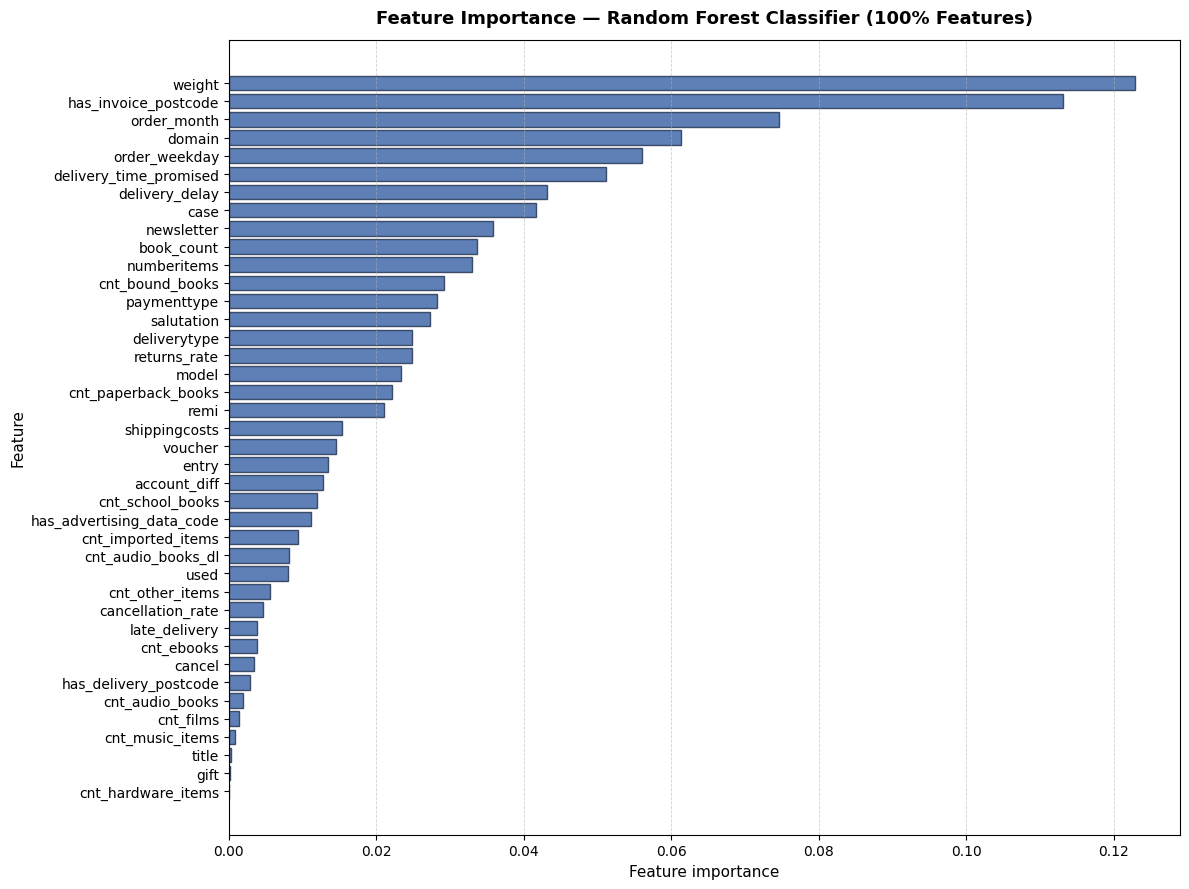

In [23]:
feature_names_rf_full = X_train.columns

feat_importance_rf_full = pd.DataFrame({
    "model": "Random Forest Classifier (100% Features)",
    "feature": feature_names_rf_full,
    "importance": best_rf_full.feature_importances_,
})
feat_importance_df = pd.concat(
    [feat_importance_df, feat_importance_rf_full],
    axis=0,
    ignore_index=True,
)
plt_feat_imp(
    fi_df=feat_importance_rf_full,
    model_name="Random Forest Classifier (100% Features)",
)

#### Model Training after Feature Selection
We only use the top 67% of features for the model training. <br>

In [24]:
rf_fi_current = feat_importance_rf_full.copy()

n_drop_rf = int(len(rf_fi_current) * 0.33)

lowest_featimps_rf = (
    rf_fi_current
    .sort_values(by="importance", ascending=True)
    .head(n_drop_rf)["feature"]
    .tolist()
)

X_train_rf_reduced = X_train.drop(columns=lowest_featimps_rf)
X_val_rf_reduced   = X_val.drop(columns=lowest_featimps_rf)


In [25]:
rf_reduced_params = {
    "model_name": "RandomForest_selected_features",
    "random_state": 42,
    "n_jobs": -1,
}

rf_reduced_param_space = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "n_estimators": [100, 200],
    "max_features": ["sqrt", "log2"],
}

rf_reduced_search_params = {
    "n_iter": 20,
    "cv": 3,
    "scoring": "neg_log_loss",
    "n_jobs": -1,
    "random_state": 42,
    "verbose": 1,
}

In [26]:
rf_clf_reduced = RandomForestClassifier(
    random_state=rf_reduced_params["random_state"],
    n_jobs=rf_reduced_params["n_jobs"],
)

rf_search_reduced = RandomizedSearchCV(
    estimator=rf_clf_reduced,
    param_distributions=rf_reduced_param_space,
    n_iter=rf_reduced_search_params["n_iter"],
    cv=rf_reduced_search_params["cv"],
    scoring=rf_reduced_search_params["scoring"],
    n_jobs=rf_reduced_search_params["n_jobs"],
    random_state=rf_reduced_search_params["random_state"],
    verbose=rf_reduced_search_params["verbose"],
)

rf_search_reduced.fit(X_train_rf_reduced, y_train)

best_rf_reduced = rf_search_reduced.best_estimator_

calibrated_rf_reduced = CalibratedClassifierCV(
    best_rf_reduced,
    method="isotonic",
    cv=3,
)

calibrated_rf_reduced.fit(X_train_rf_reduced, y_train)

y_train_proba_rf_reduced = calibrated_rf_reduced.predict_proba(X_train_rf_reduced)[:, 1]
y_val_proba_rf_reduced   = calibrated_rf_reduced.predict_proba(X_val_rf_reduced)[:, 1]

model_metrics_df = evaluate_classification_metrics(
    model="Random Forest Classifier (Selected Features)",
    df=model_metrics_df,
    y_train=y_train,
    y_train_proba=y_train_proba_rf_reduced,
    y_val=y_val,
    y_val_proba=y_val_proba_rf_reduced,
)

best_threshold_rf_reduced = find_best_threshold(
    y_val,
    y_val_proba_rf_reduced,
)

joblib.dump(
    {
        "model_name": "RandomForest_selected_features",
        "model": calibrated_rf_reduced,
        "best_estimator": best_rf_reduced,
        "best_params": rf_search_reduced.best_params_,
        "threshold": best_threshold_rf_reduced,
        "features": X_train_rf_reduced.columns.tolist(),
        "dropped_features": lowest_featimps_rf,
        "param_space": rf_reduced_param_space,
        "search_params": rf_reduced_search_params,
    },
    "rf_reduced_selected_features.pkl",
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Threshold for maximum validation revenue: 0.20
+-----------+------------+------------+
|  Metric   |   Train    | Validation |
+-----------+------------+------------+
| Accuracy  |  73.54 %   |  63.91 %   |
|  ROC AUC  |  84.57 %   |  64.04 %   |
| Precision |  94.56 %   |  87.06 %   |
|  Recall   |  71.56 %   |  65.50 %   |
| F1 Score  |  81.47 %   |  74.75 %   |
|  Revenue  | 14520.00 € | 1757.50 €  |
+-----------+------------+------------+


['rf_reduced_selected_features.pkl']

In [27]:
# ---- TRAINING SET ----
print("\033[1mConfusion Matrix – Training Set:\033[0m")
y_train_pred_rf_reduced = (y_train_proba_rf_reduced > best_threshold_rf_reduced).astype(int)
print(confusion_matrix(y_train, y_train_pred_rf_reduced))

# ---- VALIDATION SET ----
print("\033[1mConfusion Matrix – Validation Set:\033[0m")
y_val_pred_rf_reduced = (y_val_proba_rf_reduced > best_threshold_rf_reduced).astype(int)
print(confusion_matrix(y_val, y_val_pred_rf_reduced))

Confusion Matrix – Training Set:
[[15174  5911]
 [  894  3963]]
Confusion Matrix – Validation Set:
[[3485 1807]
 [ 526  668]]


## AdaBoost
In the following code snippets, we implement a AdaBoost Classifier and train it on the training data. We also finetune the hyperparemeters. <br>

## Data Preparation and Training

In [28]:
adab_full_params = {
    "model_name": "AdaBoost_100pct_features",
    "random_state": 42,
}

base_tree_full = DecisionTreeClassifier(
    random_state=adab_full_params["random_state"]
)

adab_full_param_space = {
    "estimator__max_depth": [1, 2, 3],
    "estimator__min_samples_leaf": [1, 5],
    "n_estimators": range(50, 200, 10),
    "learning_rate": [round(i, 3) for i in np.arange(0.001, 0.1, 0.005)],
}

adab_full_search_params = {
    "n_iter": 30,
    "cv": 2,
    "scoring": "neg_log_loss",
    "n_jobs": -1,
    "verbose": 1,
    "random_state": 42,
}

In [29]:
adab_clf_full = AdaBoostClassifier(
    estimator=base_tree_full,
    random_state=adab_full_params["random_state"],
)

adab_search_full = RandomizedSearchCV(
    estimator=adab_clf_full,
    param_distributions=adab_full_param_space,
    n_iter=adab_full_search_params["n_iter"],
    cv=adab_full_search_params["cv"],
    scoring=adab_full_search_params["scoring"],
    n_jobs=adab_full_search_params["n_jobs"],
    random_state=adab_full_search_params["random_state"],
    verbose=adab_full_search_params["verbose"],
)

adab_search_full.fit(X_train, y_train)

best_adab_full = adab_search_full.best_estimator_

calibrated_adab_full = CalibratedClassifierCV(
    best_adab_full,
    method="isotonic",
    cv=3,
)
calibrated_adab_full.fit(X_train, y_train)

y_train_proba_adab_full = calibrated_adab_full.predict_proba(X_train)[:, 1]
y_val_proba_adab_full   = calibrated_adab_full.predict_proba(X_val)[:, 1]

model_metrics_df = evaluate_classification_metrics(
    model="AdaBoost Classifier (100% Features)",
    df=model_metrics_df,
    y_train=y_train,
    y_train_proba=y_train_proba_adab_full,
    y_val=y_val,
    y_val_proba=y_val_proba_adab_full,
)


best_threshold_adab_full = find_best_threshold(
    y_val,
    y_val_proba_adab_full
)

joblib.dump(
    {
        "model_name": "AdaBoost_100pct_features",
        "model": calibrated_adab_full,
        "best_estimator": best_adab_full,
        "best_params": adab_search_full.best_params_,
        "threshold": best_threshold_adab_full,
        "features": X_train.columns.tolist(),
        "param_space": adab_full_param_space,
        "search_params": adab_full_search_params,
    },
    "adab_full_100pct.pkl",
)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Threshold for maximum validation revenue: 0.20
+-----------+-----------+------------+
|  Metric   |   Train   | Validation |
+-----------+-----------+------------+
| Accuracy  |  64.64 %  |  64.11 %   |
|  ROC AUC  |  64.62 %  |  62.96 %   |
| Precision |  86.05 %  |  86.13 %   |
|  Recall   |  67.42 %  |  66.76 %   |
| F1 Score  |  75.60 %  |  75.22 %   |
|  Revenue  | 6245.00 € | 1571.25 €  |
+-----------+-----------+------------+


['adab_full_100pct.pkl']

In [30]:
# ---- TRAINING SET ----
print("\033[1mConfusion Matrix – Training Set:\033[0m")
y_train_pred_adab_full = (y_train_proba_adab_full >= best_threshold_adab_full).astype(int)
print(confusion_matrix(y_train, y_train_pred_adab_full))

# ---- VALIDATION SET ----
print("\033[1mConfusion Matrix – Validation Set:\033[0m")
y_val_pred_adab_full = (y_val_proba_adab_full >= best_threshold_adab_full).astype(int)
print(confusion_matrix(y_val, y_val_pred_adab_full))

Confusion Matrix – Training Set:
[[14204  6881]
 [ 2303  2554]]
Confusion Matrix – Validation Set:
[[3527 1765]
 [ 569  625]]


## Feature Importance

In [31]:
# ---- ACCESS FEATURE IMPORTANCE: ADABOOST (100% FEATURES) ----

feat_importance_adab_full = pd.DataFrame({
    "model": "AdaBoost Classifier (100% Features)",
    "feature": X_train.columns,
    "importance": best_adab_full.feature_importances_,
})

# append safely to global tracker
feat_importance_df = pd.concat(
    [feat_importance_df, feat_importance_adab_full],
    axis=0,
    ignore_index=True,
)


In [32]:
# ---- DROP LOWEST 33% (ADABOOST-ONLY, LENGTH-SAFE) ----

adab_fi_current = feat_importance_adab_full.copy()
n_drop_adab = int(len(adab_fi_current) * 0.33)

lowest_featimps_adab = (
    adab_fi_current
    .sort_values(by="importance", ascending=True)
    .head(n_drop_adab)["feature"]
    .tolist()
)

# ---- REDUCED FEATURE MATRICES (NAME-SCOPED) ----
X_train_adab_reduced = X_train.drop(columns=lowest_featimps_adab)
X_val_adab_reduced   = X_val.drop(columns=lowest_featimps_adab)

In [33]:
adab_reduced_params = {
    "model_name": "AdaBoost_selected_features",
    "random_state": 42,
}

base_tree_reduced = DecisionTreeClassifier(
    random_state=adab_reduced_params["random_state"]
)

adab_reduced_param_space = {
    "estimator__max_depth": [1, 2, 3, 5],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 5, 10],
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
}

adab_reduced_search_params = {
    "n_iter": 30,
    "cv": 2,
    "scoring": "neg_log_loss",
    "n_jobs": -1,
    "verbose": 1,
    "random_state": 42,
}

In [34]:
adab_clf_reduced = AdaBoostClassifier(
    estimator=base_tree_reduced,
    random_state=adab_reduced_params["random_state"],
)

adab_search_reduced = RandomizedSearchCV(
    estimator=adab_clf_reduced,
    param_distributions=adab_reduced_param_space,
    n_iter=adab_reduced_search_params["n_iter"],
    cv=adab_reduced_search_params["cv"],
    scoring=adab_reduced_search_params["scoring"],
    n_jobs=adab_reduced_search_params["n_jobs"],
    random_state=adab_reduced_search_params["random_state"],
    verbose=adab_reduced_search_params["verbose"],
)

adab_search_reduced.fit(X_train_adab_reduced, y_train)

best_adab_reduced = adab_search_reduced.best_estimator_

calibrated_adab_reduced = CalibratedClassifierCV(
    best_adab_reduced,
    method="isotonic",
    cv=3,
)
calibrated_adab_reduced.fit(X_train_adab_reduced, y_train)

y_train_proba_adab_reduced = calibrated_adab_reduced.predict_proba(X_train_adab_reduced)[:, 1]
y_val_proba_adab_reduced   = calibrated_adab_reduced.predict_proba(X_val_adab_reduced)[:, 1]

model_metrics_df = evaluate_classification_metrics(
    model="AdaBoost Classifier (Selected Features)",
    df=model_metrics_df,
    y_train=y_train,
    y_train_proba=y_train_proba_adab_reduced,
    y_val=y_val,
    y_val_proba=y_val_proba_adab_reduced,
)


best_threshold_adab_reduced = find_best_threshold(
    y_val,
    y_val_proba_adab_reduced,
)

joblib.dump(
    {
        "model_name": "AdaBoost_selected_features",
        "model": calibrated_adab_reduced,
        "best_estimator": best_adab_reduced,
        "best_params": adab_search_reduced.best_params_,
        "threshold": best_threshold_adab_reduced,
        "features": X_train_adab_reduced.columns.tolist(),
        "dropped_features": lowest_featimps_adab,
        "param_space": adab_reduced_param_space,
        "search_params": adab_reduced_search_params,
    },
    "adab_reduced_selected_features.pkl",
)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Threshold for maximum validation revenue: 0.19
+-----------+-----------+------------+
|  Metric   |   Train   | Validation |
+-----------+-----------+------------+
| Accuracy  |  62.89 %  |  61.95 %   |
|  ROC AUC  |  67.04 %  |  63.62 %   |
| Precision |  87.51 %  |  86.77 %   |
|  Recall   |  63.38 %  |  62.96 %   |
| F1 Score  |  73.52 %  |  72.97 %   |
|  Revenue  | 7170.00 € | 1625.00 €  |
+-----------+-----------+------------+


['adab_reduced_selected_features.pkl']

In [35]:
# ---- TRAINING SET ----
print("\033[1mConfusion Matrix – Training Set:\033[0m")
y_train_pred_adab_reduced = (y_train_proba_adab_reduced > best_threshold_adab_reduced).astype(int)
print(confusion_matrix(y_train, y_train_pred_adab_reduced))

# ---- VALIDATION SET ----
print("\033[1mConfusion Matrix – Validation Set:\033[0m")
y_val_pred_adab_reduced = (y_val_proba_adab_reduced > best_threshold_adab_reduced).astype(int)
print(confusion_matrix(y_val, y_val_pred_adab_reduced))

Confusion Matrix – Training Set:
[[13274  7811]
 [ 1892  2965]]
Confusion Matrix – Validation Set:
[[3315 1977]
 [ 506  688]]


## Gradient Boosting

In [36]:
gb_full_params = {
    "model_name": "GradientBoosting_100pct_features",
    "random_state": 42,
}

gb_full_param_space = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "max_features": ["sqrt", "log2", None],
}

gb_full_search_params = {
    "n_iter": 30,
    "cv": 3,
    "scoring": "neg_log_loss",
    "n_jobs": -1,
    "verbose": 1,
    "random_state": 42,
}

In [37]:
gb_clf_full = GradientBoostingClassifier(
    random_state=gb_full_params["random_state"]
)

gb_search_full = RandomizedSearchCV(
    estimator=rf_clf_full,
    param_distributions=rf_full_param_space,
    n_iter=rf_full_search_params["n_iter"],
    cv=rf_full_search_params["cv"],
    scoring="neg_log_loss",      
    n_jobs=rf_full_search_params["n_jobs"],
    random_state=rf_full_search_params["random_state"],
    verbose=rf_full_search_params["verbose"],
)

gb_search_full.fit(X_train, y_train)

best_gb_full = gb_search_full.best_estimator_

calibrated_gb_full = CalibratedClassifierCV(
    best_gb_full,
    method="isotonic",
    cv=3,
)
calibrated_gb_full.fit(X_train, y_train)

y_train_proba_gb_full = calibrated_gb_full.predict_proba(X_train)[:, 1]
y_val_proba_gb_full   = calibrated_gb_full.predict_proba(X_val)[:, 1]

model_metrics_df = evaluate_classification_metrics(
    model="Gradient Boosting Classifier (100% Features)",
    df=model_metrics_df,
    y_train=y_train,
    y_train_proba=y_train_proba_gb_full,
    y_val=y_val,
    y_val_proba=y_val_proba_gb_full,
)

best_threshold_gb_full = find_best_threshold(
    y_val,
    y_val_proba_gb_full,
)

joblib.dump(
    {
        "model_name": "GradientBoosting_100pct_features",
        "model": calibrated_gb_full,
        "best_estimator": best_gb_full,
        "best_params": gb_search_full.best_params_,
        "threshold": best_threshold_gb_full,
        "features": X_train.columns.tolist(),
        "param_space": gb_full_param_space,
        "search_params": gb_full_search_params,
    },
    "gb_full_100pct.pkl",
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Threshold for maximum validation revenue: 0.21
+-----------+------------+------------+
|  Metric   |   Train    | Validation |
+-----------+------------+------------+
| Accuracy  |  72.81 %   |  64.43 %   |
|  ROC AUC  |  82.43 %   |  63.84 %   |
| Precision |  92.65 %   |  86.70 %   |
|  Recall   |  72.29 %   |  66.63 %   |
| F1 Score  |  81.21 %   |  75.35 %   |
|  Revenue  | 13002.50 € | 1702.50 €  |
+-----------+------------+------------+


['gb_full_100pct.pkl']

In [38]:
# ---- TRAINING SET ----
print("\033[1mConfusion Matrix – Training Set:\033[0m")
y_train_pred_gb_full = (y_train_proba_gb_full >= best_threshold_gb_full).astype(int)
print(confusion_matrix(y_train, y_train_pred_gb_full))

# ---- VALIDATION SET ----
print("\033[1mConfusion Matrix – Validation Set:\033[0m")
y_val_pred_gb_full = (y_val_proba_gb_full >= best_threshold_gb_full).astype(int)
print(confusion_matrix(y_val, y_val_pred_gb_full))

Confusion Matrix – Training Set:
[[15299  5786]
 [ 1226  3631]]
Confusion Matrix – Validation Set:
[[3543 1749]
 [ 547  647]]


In [39]:
# ---- ACCESS FEATURE IMPORTANCE: GRADIENT BOOSTING (100% FEATURES) ----

feat_importance_gb_full = pd.DataFrame({
    "model": "Gradient Boosting Classifier (100% Features)",
    "feature": X_train.columns,
    "importance": best_gb_full.feature_importances_,
})

# append safely to global tracker
feat_importance_df = pd.concat(
    [feat_importance_df, feat_importance_gb_full],
    axis=0,
    ignore_index=True,
)

# ---- DROP LOWEST 33% (GB-ONLY, LENGTH-SAFE) ----

gb_fi_current = feat_importance_gb_full.copy()
n_drop_gb = int(len(gb_fi_current) * 0.33)

lowest_featimps_gb = (
    gb_fi_current
    .sort_values(by="importance", ascending=True)
    .head(n_drop_gb)["feature"]
    .tolist()
)

# ---- REDUCED FEATURE MATRICES (NAME-SCOPED) ----
X_train_gb_reduced = X_train.drop(columns=lowest_featimps_gb)
X_val_gb_reduced   = X_val.drop(columns=lowest_featimps_gb)

In [40]:
gb_reduced_params = {
    "model_name": "GradientBoosting_selected_features",
    "random_state": 42,
}

gb_reduced_param_space = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "max_features": ["sqrt", "log2", None],
}

gb_reduced_search_params = {
    "n_iter": 30,
    "cv": 3,
    "scoring": "neg_log_loss",
    "n_jobs": -1,
    "verbose": 1,
    "random_state": 42,
}

In [41]:
gb_clf_reduced = GradientBoostingClassifier(
    random_state=gb_reduced_params["random_state"]
)

gb_search_reduced =  RandomizedSearchCV(
    estimator=rf_clf_full,
    param_distributions=rf_full_param_space,
    n_iter=rf_full_search_params["n_iter"],
    cv=rf_full_search_params["cv"],
    scoring="neg_log_loss",      
    n_jobs=rf_full_search_params["n_jobs"],
    random_state=rf_full_search_params["random_state"],
    verbose=rf_full_search_params["verbose"],
)

gb_search_reduced.fit(X_train_gb_reduced, y_train)

best_gb_reduced = gb_search_reduced.best_estimator_

calibrated_gb_reduced = CalibratedClassifierCV(
    best_gb_reduced,
    method="isotonic",
    cv=3,
)
calibrated_gb_reduced.fit(X_train_gb_reduced, y_train)

y_train_proba_gb_reduced = calibrated_gb_reduced.predict_proba(X_train_gb_reduced)[:, 1]
y_val_proba_gb_reduced   = calibrated_gb_reduced.predict_proba(X_val_gb_reduced)[:, 1]

model_metrics_df = evaluate_classification_metrics(
    model="Gradient Boosting Classifier (Selected Features)",
    df=model_metrics_df,
    y_train=y_train,
    y_train_proba=y_train_proba_gb_reduced,
    y_val=y_val,
    y_val_proba=y_val_proba_gb_reduced,
)

best_threshold_gb_reduced = find_best_threshold(
    y_val,
    y_val_proba_gb_reduced,
)

joblib.dump(
    {
        "model_name": "GradientBoosting_selected_features",
        "model": calibrated_gb_reduced,
        "best_estimator": best_gb_reduced,
        "best_params": gb_search_reduced.best_params_,
        "threshold": best_threshold_gb_reduced,
        "features": X_train_gb_reduced.columns.tolist(),
        "dropped_features": lowest_featimps_gb,
        "param_space": gb_reduced_param_space,
        "search_params": gb_reduced_search_params,
    },
    "gb_reduced_selected_features.pkl",
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Threshold for maximum validation revenue: 0.20
+-----------+------------+------------+
|  Metric   |   Train    | Validation |
+-----------+------------+------------+
| Accuracy  |  73.54 %   |  63.91 %   |
|  ROC AUC  |  84.57 %   |  64.04 %   |
| Precision |  94.56 %   |  87.06 %   |
|  Recall   |  71.56 %   |  65.50 %   |
| F1 Score  |  81.47 %   |  74.75 %   |
|  Revenue  | 14520.00 € | 1757.50 €  |
+-----------+------------+------------+


['gb_reduced_selected_features.pkl']

In [42]:


# ---- TRAINING SET ----
print("\033[1mConfusion Matrix – Training Set:\033[0m")
y_train_pred_gb_reduced = (y_train_proba_gb_reduced > best_threshold_gb_reduced).astype(int)
print(confusion_matrix(y_train, y_train_pred_gb_reduced))

# ---- VALIDATION SET ----
print("\033[1mConfusion Matrix – Validation Set:\033[0m")
y_val_pred_gb_reduced = (y_val_proba_gb_reduced > best_threshold_gb_reduced).astype(int)
print(confusion_matrix(y_val, y_val_pred_gb_reduced))

Confusion Matrix – Training Set:
[[15174  5911]
 [  894  3963]]
Confusion Matrix – Validation Set:
[[3485 1807]
 [ 526  668]]


### Ensemble Model
Now we build an ensemble model with the best 3 models. We will compare its performance with the other models to decide which model to use for the final predictions.

In [43]:
def ensemble_model_6models(
    X: pd.DataFrame,
    model_performances_df: pd.DataFrame,
    preds_or_probas: str = "proba",
) -> np.ndarray:
    """
    Ensemble model for 6 models:
    RF, AdaBoost, Gradient Boosting × (100% Features, Selected Features)
    """

    # --------------------------------------------------
    # 1. Order by validation revenue
    # --------------------------------------------------
    model_performances_df = (
        model_performances_df[model_performances_df["dataset"] == "val"]
        .sort_values(by="revenue", ascending=False)
        .reset_index(drop=True)
    )

    # Drop any existing ensemble rows
    model_performances_df = model_performances_df[
        model_performances_df["model"] != "Final Ensemble Model"
    ]

    # --------------------------------------------------
    # 2. Keep best variant per algorithm
    # --------------------------------------------------
    def keep_best(df, name_full, name_reduced):
        if name_full in df["model"].values and name_reduced in df["model"].values:
            rev_full = df.loc[df["model"] == name_full, "revenue"].values[0]
            rev_red  = df.loc[df["model"] == name_reduced, "revenue"].values[0]
            if rev_red > rev_full:
                df = df[df["model"] != name_full]
            else:
                df = df[df["model"] != name_reduced]
        return df

    model_performances_df = keep_best(
        model_performances_df,
        "Random Forest Classifier (100% Features)",
        "Random Forest Classifier (Selected Features)",
    )

    model_performances_df = keep_best(
        model_performances_df,
        "AdaBoost Classifier (100% Features)",
        "AdaBoost Classifier (Selected Features)",
    )

    model_performances_df = keep_best(
        model_performances_df,
        "Gradient Boosting Classifier (100% Features)",
        "Gradient Boosting Classifier (Selected Features)",
    )

    # --------------------------------------------------
    # 3. Select best 3 models
    # --------------------------------------------------
    model_performances_df = model_performances_df.iloc[:3].reset_index(drop=True)

    print("\033[1mBest 3 models:\033[0m")
    print(model_performances_df[["model", "revenue"]])

    # --------------------------------------------------
    # 4. Initialize outputs
    # --------------------------------------------------
    outputs = []

    # --------------------------------------------------
    # 5. Load models + predict
    # --------------------------------------------------
    for _, row in model_performances_df.iterrows():
        model_name = row["model"]

        if model_name == "Random Forest Classifier (100% Features)":
            ckpt = joblib.load("rf_full_100pct.pkl")
            X_use = X[ckpt["features"]]

        elif model_name == "Random Forest Classifier (Selected Features)":
            ckpt = joblib.load("rf_reduced_selected_features.pkl")
            X_use = X[ckpt["features"]]

        elif model_name == "AdaBoost Classifier (100% Features)":
            ckpt = joblib.load("adab_full_100pct.pkl")
            X_use = X[ckpt["features"]]

        elif model_name == "AdaBoost Classifier (Selected Features)":
            ckpt = joblib.load("adab_reduced_selected_features.pkl")
            X_use = X[ckpt["features"]]

        elif model_name == "Gradient Boosting Classifier (100% Features)":
            ckpt = joblib.load("gb_full_100pct.pkl")
            X_use = X[ckpt["features"]]

        elif model_name == "Gradient Boosting Classifier (Selected Features)":
            ckpt = joblib.load("gb_reduced_selected_features.pkl")
            X_use = X[ckpt["features"]]

        else:
            continue

        model = ckpt["model"]
        threshold = ckpt["threshold"]
        proba = model.predict_proba(X_use)[:, 1]

        if preds_or_probas == "pred":
            outputs.append((proba > threshold).astype(int))
        elif preds_or_probas == "proba":
            outputs.append(proba)
        else:
            raise ValueError("preds_or_probas must be 'pred' or 'proba'")

    # --------------------------------------------------
    # 6. Aggregate (mean vote)
    # --------------------------------------------------
    outputs = np.vstack(outputs)
    avg = outputs.mean(axis=0)

    if preds_or_probas == "pred":
        return (avg > 0.5).astype(int)
    else:
        return avg

In [44]:
# Predict ensemble probabilities on the training set
y_train_proba_ens = ensemble_model_6models(
    X=X_train,
    model_performances_df=model_metrics_df,
    preds_or_probas="proba",
)

y_val_proba_ens = ensemble_model_6models(
    X=X_val,
    model_performances_df=model_metrics_df,
    preds_or_probas="proba",
)

Best 3 models:
                                              model    revenue
0      Random Forest Classifier (Selected Features)  1757.50 €
1  Gradient Boosting Classifier (Selected Features)  1757.50 €
2           AdaBoost Classifier (Selected Features)  1625.00 €
Best 3 models:
                                              model    revenue
0      Random Forest Classifier (Selected Features)  1757.50 €
1  Gradient Boosting Classifier (Selected Features)  1757.50 €
2           AdaBoost Classifier (Selected Features)  1625.00 €


In [45]:
# Evaluate the final ensemble model
model_metrics_df = evaluate_classification_metrics(
    model="Final Ensemble Model",
    df=model_metrics_df,
    y_train=y_train,
    y_train_proba=y_train_proba_ens,
    y_val=y_val,
    y_val_proba=y_val_proba_ens,
)

model_metrics_df

joblib.dump(
    {
        "model_name": "Final Ensemble Model",
        "model": "Final Ensemble Model",                    # ensemble handled procedurally
        "best_estimator": None,            # not applicable
        "best_params": None,               # not applicable
        "threshold": 0.5,                  # placeholder, overridden downstream
        "features": X_train.columns.tolist(),  # full feature space
        "dropped_features": [],            # none at ensemble level
        "param_space": None,               # not applicable
        "search_params": None,             # not applicable
    },
    "final_ensemble_model.pkl",
)

/Users/ck/jupyter-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Threshold for maximum validation revenue: 0.20
+-----------+------------+------------+
|  Metric   |   Train    | Validation |
+-----------+------------+------------+
| Accuracy  |  71.73 %   |  64.92 %   |
|  ROC AUC  |  80.03 %   |  64.26 %   |
| Precision |  91.83 %   |  86.80 %   |
|  Recall   |  71.59 %   |  67.23 %   |
| F1 Score  |  80.46 %   |  75.77 %   |
|  Revenue  | 12157.50 € | 1742.50 €  |
+-----------+------------+------------+


['final_ensemble_model.pkl']

In [46]:

def expected_revenue_unlabeled(y_prob, threshold):
    """
    Expected revenue under the voucher policy:
    send voucher if P(reorder) < threshold
    """
    send_voucher = y_prob < threshold

    revenue = np.zeros(len(y_prob))

    # Voucher sent
    revenue[send_voucher] = (
        (1 - y_prob[send_voucher]) * 1.25   # saved churners
        + y_prob[send_voucher] * (-5.0)     # wasted vouchers
    )

    # No voucher → zero revenue impact (already zero)

    return revenue.sum()

In [59]:

model_files = [
    "rf_full_100pct.pkl",
    # "rf_reduced_selected_features.pkl",
    # "adab_full_100pct.pkl",
    # "adab_reduced_selected_features.pkl",
    # "gb_full_100pct.pkl",
    # "gb_reduced_selected_features.pkl",
    # "final_ensemble_model.pkl",
]

print("\nTest expected revenue per model:")

for path in model_files:
    ckpt = joblib.load(path)

    model = ckpt["model"]
    features = ckpt["features"]
    threshold = ckpt["threshold"]

    X_use = X_test[features]
    y_proba = calibrated_rf_full.predict_proba(X_use)[:, 1]

    # y_train_proba_gb_reduced = calibrated_gb_reduced.predict_proba(X_train_gb_reduced)[:, 1]
    # y_val_proba_gb_reduced   = calibrated_gb_reduced.predict_proba(X_val_gb_reduced)[:, 1]

    revenue = expected_revenue_unlabeled(
        y_proba,
        threshold,
    )

    print(f"{ckpt['model_name']:<40} {revenue:,.2f} €")


Test expected revenue per model:
RandomForest_100pct_features             9,044.50 €
